In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/College/Msc IT/SEM - 3/Neural Network and Deep Learning/Coursework/Academic Stress detection

/content/drive/MyDrive/College/Msc IT/SEM - 3/Neural Network and Deep Learning/Coursework/Academic Stress detection


In [6]:
#cloning repo
!git clone https://github.com/Prakritin11/Academic-stress-detection.git


Cloning into 'Academic-stress-detection'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [7]:
%cd Academic-stress-detection
!pwd

/content/drive/MyDrive/College/Msc IT/SEM - 3/Neural Network and Deep Learning/Coursework/Academic Stress detection/Academic-stress-detection
/content/drive/MyDrive/College/Msc IT/SEM - 3/Neural Network and Deep Learning/Coursework/Academic Stress detection/Academic-stress-detection


In [ ]:
#creating folder
!mkdir -p data notebooks
#moving notebook into the folder
!cp "/content/19031355 PRAKRITI NIROULA.ipynb" ./notebooks/


In [18]:
#imports
import pandas as pd
import numpy as np
import random


In [19]:
#define stress Lables

stress_labels = ["Low", "Moderate", "High"]

In [20]:
#self- reflective texts

# Base templates for reflective texts
low_templates = [
    "I am feeling calm and confident while completing my {aspect}.",
    "This week, I managed my {aspect} smoothly without any stress.",
    "I am satisfied with my progress in {aspect} and feel relaxed.",
    "Balancing my {aspect} along with personal time is going well.",
    "I feel positive about my {aspect} and upcoming tasks."
]

moderate_templates = [
    "I feel a bit stressed about managing my {aspect} on time.",
    "The {aspect} workload is increasing, causing mild anxiety.",
    "I am trying to stay on top of my {aspect}, but it feels challenging.",
    "Sometimes I worry about finishing my {aspect} before deadlines.",
    "I feel some pressure while balancing {aspect} with other responsibilities."
]

high_templates = [
    "I feel overwhelmed by my {aspect} and struggle to cope with deadlines.",
    "The stress from {aspect} is affecting my focus and mental well-being.",
    "I am panicked about completing my {aspect} and feel anxious constantly.",
    "Managing my {aspect} feels impossible and I am extremely stressed.",
    "I am frustrated and worried that I cannot keep up with my {aspect} workload."
]

# Word banks
aspects = ["assignments", "projects", "coursework", "exams", "academic work"]



In [21]:
#function to generate texts

def generate_text(templates, n):
    texts = []
    for _ in range(n):
        template = random.choice(templates)
        text = template.format(
            aspect=random.choice(aspects)
        )
        texts.append(text)
    return texts

# generate dataset
low_stress_texts = generate_text(low_templates, 100)
moderate_stress_texts = generate_text(moderate_templates, 100)
high_stress_texts = generate_text(high_templates, 100)

#combine all texts with lables
data = []
for text in low_stress_texts:
    data.append([text, "Low"])
for text in moderate_stress_texts:
    data.append([text, "Moderate"])
for text in high_stress_texts:
    data.append([text, "High"])

#create dataFrame and shuffle
df = pd.DataFrame(data, columns=["text", "label"])
df = df.sample(frac=1).reset_index(drop=True)

#save CSV
df.to_csv("academic_stress_reflections.csv", index=False)

#review
print("Dataset shape:", df.shape)
print(df.head())
print("\nLabel distribution:\n", df["label"].value_counts())


Dataset shape: (300, 2)
                                                text     label
0  I am satisfied with my progress in projects an...       Low
1  The stress from academic work is affecting my ...      High
2  The academic work workload is increasing, caus...  Moderate
3  Managing my exams feels impossible and I am ex...      High
4  The coursework workload is increasing, causing...  Moderate

Label distribution:
 label
Low         100
High        100
Moderate    100
Name: count, dtype: int64


In [22]:
#label encoding

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
print(df.head())


                                                text     label  label_encoded
0  I am satisfied with my progress in projects an...       Low              1
1  The stress from academic work is affecting my ...      High              0
2  The academic work workload is increasing, caus...  Moderate              2
3  Managing my exams feels impossible and I am ex...      High              0
4  The coursework workload is increasing, causing...  Moderate              2


In [23]:
#tokenization and vocabulary

from collections import Counter

# simple tokenizer: lowercase + split
def tokenize(text):
    return text.lower().split()

# build vocabulary
counter = Counter()
for text in df['text']:
    counter.update(tokenize(text))

# create word-to-index mapping
vocab = {word: idx+2 for idx, (word, _) in enumerate(counter.items())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1  # unknown token
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)


Vocabulary size: 104


In [24]:
#encode text to integers
def encode(text):
    return [vocab.get(word, 1) for word in tokenize(text)]

df['encoded_text'] = df['text'].apply(encode)
print(df.head())


                                                text     label  label_encoded  \
0  I am satisfied with my progress in projects an...       Low              1   
1  The stress from academic work is affecting my ...      High              0   
2  The academic work workload is increasing, caus...  Moderate              2   
3  Managing my exams feels impossible and I am ex...      High              0   
4  The coursework workload is increasing, causing...  Moderate              2   

                                      encoded_text  
0             [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  
1  [13, 14, 15, 16, 17, 18, 19, 6, 20, 10, 21, 22]  
2             [13, 16, 17, 23, 18, 24, 25, 26, 27]  
3            [28, 6, 29, 30, 31, 10, 2, 3, 32, 33]  
4                 [13, 34, 23, 18, 24, 25, 26, 27]  


In [32]:
#train/test split

from sklearn.model_selection import train_test_split

#split 70% train, 30% test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['encoded_text'], df['label_encoded'], test_size=0.3, random_state=42, stratify=df['label_encoded']
)

print("Training samples:", len(train_texts))
print("Testing samples:", len(test_texts))


Training samples: 210
Testing samples: 90


In [35]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

#custom dataset
class StressDataset(Dataset):
    def __init__(self, texts, labels):
        # Convert each text (list of integers) to torch tensor
        self.texts = [torch.tensor(t, dtype=torch.long) for t in texts]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

#collect function for dataloader(padding)
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)
    labels = torch.tensor(labels)
    return texts_padded, labels

In [36]:
#dataset and dataloader

# Custom Dataset remains the same
train_dataset = StressDataset(train_texts.tolist(), train_labels.tolist())
test_dataset = StressDataset(test_texts.tolist(), test_labels.tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Quick check
for x, y in train_loader:
    print("Batch X shape:", x.shape)
    print("Batch Y:", y)
    break



Batch X shape: torch.Size([16, 14])
Batch Y: tensor([0, 0, 2, 2, 2, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0])


In [37]:
#quick check of training batch
for x, y in train_loader:
    print("Training Batch X shape:", x.shape)
    print("Training Batch Y:", y)
    break

#quick check of testing batch
for x, y in test_loader:
    print("Testing Batch X shape:", x.shape)
    print("Testing Batch Y:", y)
    break



Training Batch X shape: torch.Size([16, 15])
Training Batch Y: tensor([2, 0, 0, 1, 0, 0, 1, 2, 0, 0, 1, 0, 2, 1, 1, 2])
Testing Batch X shape: torch.Size([16, 15])
Testing Batch Y: tensor([0, 0, 2, 1, 0, 0, 1, 1, 0, 1, 1, 1, 2, 2, 2, 0])


In [38]:
#imports
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import classification_report

#LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out

#Bi-LSTM model
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        # Concatenate forward and backward hidden states
        hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)
        out = self.fc(hidden_cat)
        return out


In [39]:

#device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [42]:
from torch.nn import CrossEntropyLoss

#initialize model (LSTM)
model = LSTMModel(vocab_size=vocab_size, embed_dim=64, hidden_dim=64, output_dim=3)
model = model.to(device)

#loss and optimizer
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [43]:
#training loop

epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/5, Loss: 1.0726
Epoch 2/5, Loss: 0.9865
Epoch 3/5, Loss: 0.7831
Epoch 4/5, Loss: 0.4177
Epoch 5/5, Loss: 0.0944


In [44]:
#evaluation

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

# Classification report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


Classification Report:

              precision    recall  f1-score   support

        High       0.94      1.00      0.97        30
         Low       1.00      0.93      0.97        30
    Moderate       1.00      1.00      1.00        30

    accuracy                           0.98        90
   macro avg       0.98      0.98      0.98        90
weighted avg       0.98      0.98      0.98        90



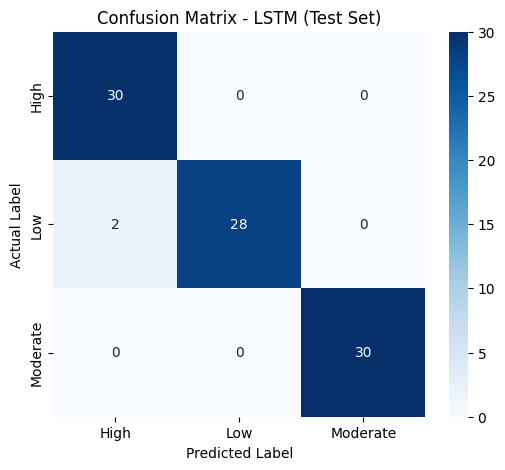

In [45]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - LSTM (Test Set)")
plt.show()


In [46]:
#saving the model
torch.save(model.state_dict(), "lstm_stress_model.pth")
print("Model saved successfully!")


Model saved successfully!


In [47]:
#Bi-LSTM initialization

bi_model = BiLSTMModel(vocab_size=vocab_size, embed_dim=64, hidden_dim=64, output_dim=3)
bi_model = bi_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(bi_model.parameters(), lr=0.001)

In [48]:
#Bi-LSTM training

epochs = 5  # keeping same as LSTM for fair comparison

for epoch in range(epochs):
    bi_model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = bi_model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/5, Loss: 1.0112
Epoch 2/5, Loss: 0.8179
Epoch 3/5, Loss: 0.4314
Epoch 4/5, Loss: 0.1295
Epoch 5/5, Loss: 0.0298


In [50]:
#evaluate Bi-LSTM on Test Set

bi_model.eval()
bi_preds = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = bi_model(x_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        bi_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

#classification Report
from sklearn.metrics import classification_report, confusion_matrix
print("\nBi-LSTM Classification Report (Test Set):\n")
print(classification_report(all_labels, bi_preds, target_names=label_encoder.classes_))




Bi-LSTM Classification Report (Test Set):

              precision    recall  f1-score   support

        High       1.00      1.00      1.00        30
         Low       1.00      1.00      1.00        30
    Moderate       1.00      1.00      1.00        30

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



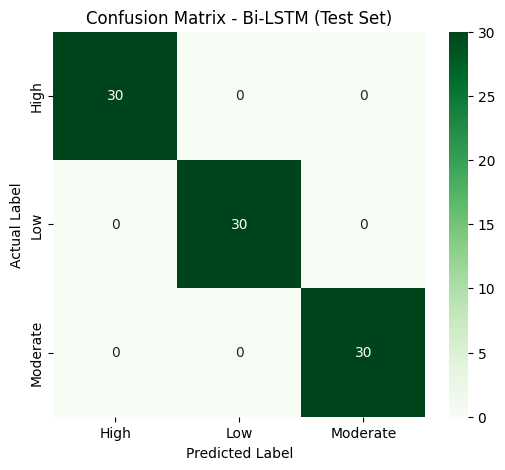

In [51]:

#confusion Matrix
cm = confusion_matrix(all_labels, bi_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Greens')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Bi-LSTM (Test Set)")
plt.show()

In [52]:
#comparision : LSTM vs Bi-LSTM

from sklearn.metrics import accuracy_score, f1_score

#LSTM metrics
lstm_acc = accuracy_score(all_labels, all_preds)
lstm_f1 = f1_score(all_labels, all_preds, average='macro')

#Bi-LSTM metrics
bi_acc = accuracy_score(all_labels, bi_preds)
bi_f1 = f1_score(all_labels, bi_preds, average='macro')

import pandas as pd
comparison_df = pd.DataFrame({
    "Model": ["LSTM", "Bi-LSTM"],
    "Accuracy": [lstm_acc, bi_acc],
    "F1-Score": [lstm_f1, bi_f1]
})

print("\nLSTM vs Bi-LSTM Performance:\n")
print(comparison_df)



LSTM vs Bi-LSTM Performance:

     Model  Accuracy  F1-Score
0     LSTM  0.977778  0.977753
1  Bi-LSTM  1.000000  1.000000
